## Mnist MoE

### Description
This notebook contains the implementation of a Mixture of Experts (MoE) model applied to the MNIST dataset.
The approach involves training multiple expert models, each specialized in handling a specific type of corrupted MNIST data, and a gating network that learns to select the appropriate expert based on the input data. This is the first implementation we did for the MoE concept. It might not reflect the real idea behind a MoE as the experts are pretrained and not trained jointly with the gating network. But as we did all this work we kept it to see the difference in terms of implementation and performances compared to other models (dense, jointly trained MoE).
This notebook includes scripts for training individual expert models on specific types of corrupted MNIST data, as well as a gating network that learns to route inputs to the appropriate expert based on the type of corruption present in the data. The transforms.py file defines various data augmentation techniques used to create corrupted versions of the MNIST images.


Experts and data alterations :
- Normal expert trained on clean MNIST data.
- Noise expert trained on MNIST data with Gaussian noise from 0 to 0.4.
- Angle expert trained on MNIST data rotated between -35 and 35 degrees.
- Blur expert trained on MNIST data with Gaussian blur applied with a kernel size of 5 and sigma between 0.1 and 2.0.

- Dense expert trained on MNIST data with a combination of all the above corruptions applied with a probability of 0.25 each (counting no alteration).

### Files
- transforms.py: Contains data augmentation functions for different types of corruptions.
- mnist_cnn.py: Defines the CNN architecture used for both experts and the gating network.
- train_experts.py: Script to train individual expert models on their respective corrupted datasets.
- gating_Mnist.py: Script to train the gating network that routes inputs to the appropriate expert.
- main.py: Main script to run the entire MoE training and evaluation process.

### Usage
__cell 1__ : Import necessary libraries (numpy, matplotlib).
__cell 2__ Train individual experts and the dense model (trained on combined corruptions) by running `train_experts` and `train_dense`. (Not needed if they already exists in Mnist_pretrained_moe/ save some times by reusing them)
__cell 3__ Train the gating network using `train_gating_network`.
__cell 4__ Evaluate the MoE model using `evaluate_gating`.
__cell 5__ Visualize expert usage distribution using matplotlib.
__cell 6__ Evaluate the MoE model per corruption and labels type using `evaluate_label_filter`.
__cell 7 8__ Visualize expert usage distribution per class and corruption type.

tips : For any function their is a "verbose" argument that can be set to True to have more information druing the execution.

In [7]:
import numpy as np
import matplotlib.pyplot as plt

expert_names = ['normal', 'angle', 'noise', 'blur']
experts_paths = {'normal': './Mnist_pretrained_moe/Mnist_pretrained_experts/expert_normal.pth',
                    'angle': './Mnist_pretrained_moe/Mnist_pretrained_experts/expert_angle.pth',
                    'noise': './Mnist_pretrained_moe/Mnist_pretrained_experts/expert_noise.pth',
                    'blur': './Mnist_pretrained_moe/Mnist_pretrained_experts/expert_blur.pth'}

In [ ]:
from Mnist_pretrained_moe.train_experts import train_experts, train_dense_expert

accuracies = {}

accuracies.update(train_experts(epochs=8, verbose=False))
accuracies.update(train_dense_expert(verbose=False))

print("\nExpert Accuracies:")
for expert, acc in accuracies.items():
    print(f"{expert}: {acc:.2f}%")


Using device: cuda

Training Expert: normal
Accuracy for normal: 98.68%
Saved normal model to ./Mnist_pretrained_moe/Mnist_pretrained_experts/expert_normal.pth

Training Expert: angle
Accuracy for angle: 97.64%
Saved angle model to ./Mnist_pretrained_moe/Mnist_pretrained_experts/expert_angle.pth

Training Expert: noise
Accuracy for noise: 96.76%
Saved noise model to ./Mnist_pretrained_moe/Mnist_pretrained_experts/expert_noise.pth

Training Expert: blur
Accuracy for blur: 98.05%
Saved blur model to ./Mnist_pretrained_moe/Mnist_pretrained_experts/expert_blur.pth
Using device: cuda

Training Expert: dense
Accuracy for dense: 98.23%
Saved dense model to ./Mnist_pretrained_moe/Mnist_pretrained_experts/expert_dense.pth

Expert Accuracies:
normal: 98.68%
angle: 97.64%
noise: 96.76%
blur: 98.05%
dense: 98.23%


In [8]:
from Mnist_pretrained_moe.gating_Mnist import train_gating_network

gating_accuracy = train_gating_network(expert_paths=experts_paths, verbose=False)


Using device: cuda
Training MoE with experts: ['normal', 'angle', 'noise', 'blur']

Starting training for 10 epochs...

--------------------------------------------------

--------------------------------------------------

--------------------------------------------------

--------------------------------------------------

--------------------------------------------------

--------------------------------------------------

--------------------------------------------------

--------------------------------------------------

--------------------------------------------------

--------------------------------------------------

Training complete! Model saved to ./Mnist_pretrained_moe/Mnist_pretrained_experts/moe_gating_model.pth


### Evaluation
After training, the performance of each expert and the gating network can be evaluated on a test set against a dense expert trained on all types of corruptions.


In [9]:
from Mnist_pretrained_moe.eval_gating import evaluate_gating

gating_eval_result = evaluate_gating()


Using device: cuda
Loading models...
Models loaded successfully!
test_loader loaded successfully! 10000 test samples

MoE Accuracy: 98.09%, Dense Accuracy: 97.93%
Expert Usage Distribution:  normal: 19.3%,  angle: 34.1%,  noise: 31.1%,  blur: 15.6%


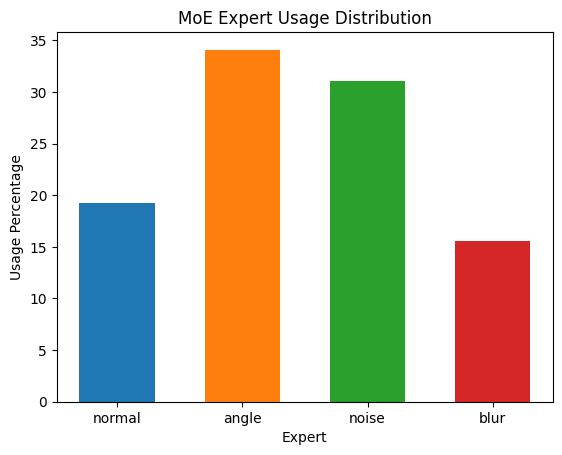

In [10]:
histo_data = gating_eval_result[2]  # Extract expert usage distribution
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Example colors for each expert
plt.bar(expert_names, histo_data * 100, width=0.6, color=colors)
plt.xlabel('Expert')
plt.ylabel('Usage Percentage')
plt.title('MoE Expert Usage Distribution')
plt.show()




## MoE distribution of expert usage relative to the classes and types of corruptions

In [11]:
from Mnist_pretrained_moe.eval_gating import evaluate_label_filter

results = {}
expert_names = ['normal', 'angle', 'noise', 'blur']

for label in range(10):
    results[label] = {}  # Initialize the inner dictionary for each label
    for alteration in ['normal', 'angle', 'noise', 'blur']:
        results[label][alteration] = evaluate_label_filter(label_filter=label, alteration=alteration)

print(results)



{0: {'normal': array([0.21187383, 0.41669238, 0.35001115, 0.02142264]), 'angle': array([0.19168852, 0.4882202 , 0.29431735, 0.02577394]), 'noise': array([0.18622332, 0.22975972, 0.57906887, 0.00494812]), 'blur': array([0.18688864, 0.43146418, 0.20637336, 0.17527382])}, 1: {'normal': array([0.22486094, 0.18484988, 0.43498844, 0.15530074]), 'angle': array([0.15839727, 0.40612018, 0.30059405, 0.13488851]), 'noise': array([0.13918666, 0.04159199, 0.81426124, 0.00496013]), 'blur': array([0.10453621, 0.18875515, 0.16815052, 0.53855812])}, 2: {'normal': array([0.39307948, 0.24863031, 0.23598003, 0.12231019]), 'angle': array([0.26497258, 0.47303029, 0.17658672, 0.08541041]), 'noise': array([0.37608346, 0.10978793, 0.50212684, 0.01200177]), 'blur': array([0.23915966, 0.23980006, 0.11992239, 0.40111789])}, 3: {'normal': array([0.21921821, 0.4313265 , 0.20653497, 0.14292033]), 'angle': array([0.13786872, 0.63394071, 0.14073362, 0.08745695]), 'noise': array([0.2295968 , 0.20499902, 0.5501565 , 0.0

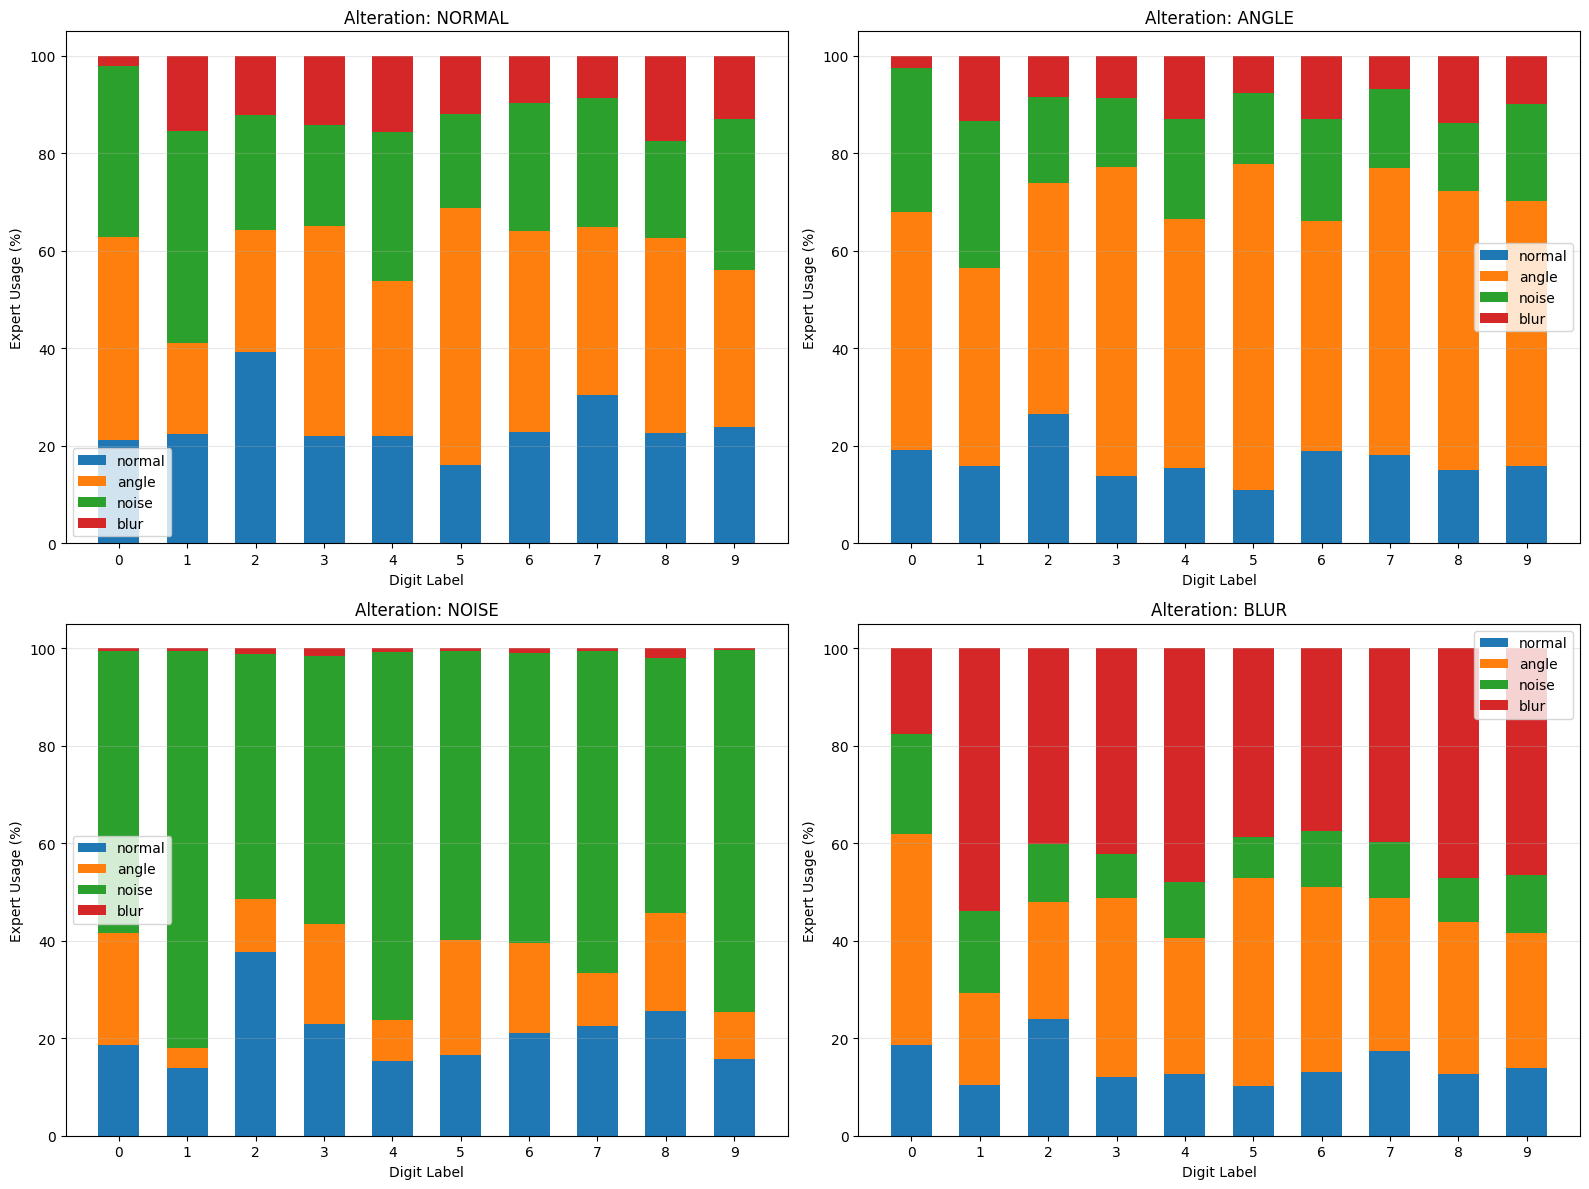

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for j, alteration in enumerate(expert_names):
    # Prepare data for this alteration
    expert_usage = np.zeros((10, 4))  # 10 labels, 4 experts
    
    for label in range(10):
        usage_array = results[label][alteration]
        expert_usage[label, :] = usage_array * 100  # Convert to percentage
    
    # Stacked bar chart
    x = np.arange(10)
    bottom = np.zeros(10)
    
    for expert_idx, expert_name in enumerate(expert_names):
        axes[j].bar(x, expert_usage[:, expert_idx], bottom=bottom, 
                   label=expert_name, color=colors[expert_idx], width=0.6)
        bottom += expert_usage[:, expert_idx]
    
    axes[j].set_xlabel('Digit Label')
    axes[j].set_ylabel('Expert Usage (%)')
    axes[j].set_title(f'Alteration: {alteration.upper()}')
    axes[j].legend()
    axes[j].set_xticks(x)
    axes[j].set_xticklabels([str(i) for i in range(10)])
    axes[j].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('expert_usage_stacked_bars.png', dpi=300, bbox_inches='tight')
plt.show()


### Repartition of expert usage per class and corruption type.

The following graph represent the distribution of expert for each labels and the four types of alteration (normal, angle, noise, blur).
We can observe that the gating network determined that the model trained on Noisy images (green) is the best in almost all the coruption cases except the blured one where the blur expert is the most used.
This method of gating with already trained expert does have some improvements in accuracy compared to a dense model but it could simply be that the noise expert is just better at generalizing to other types of corruption.



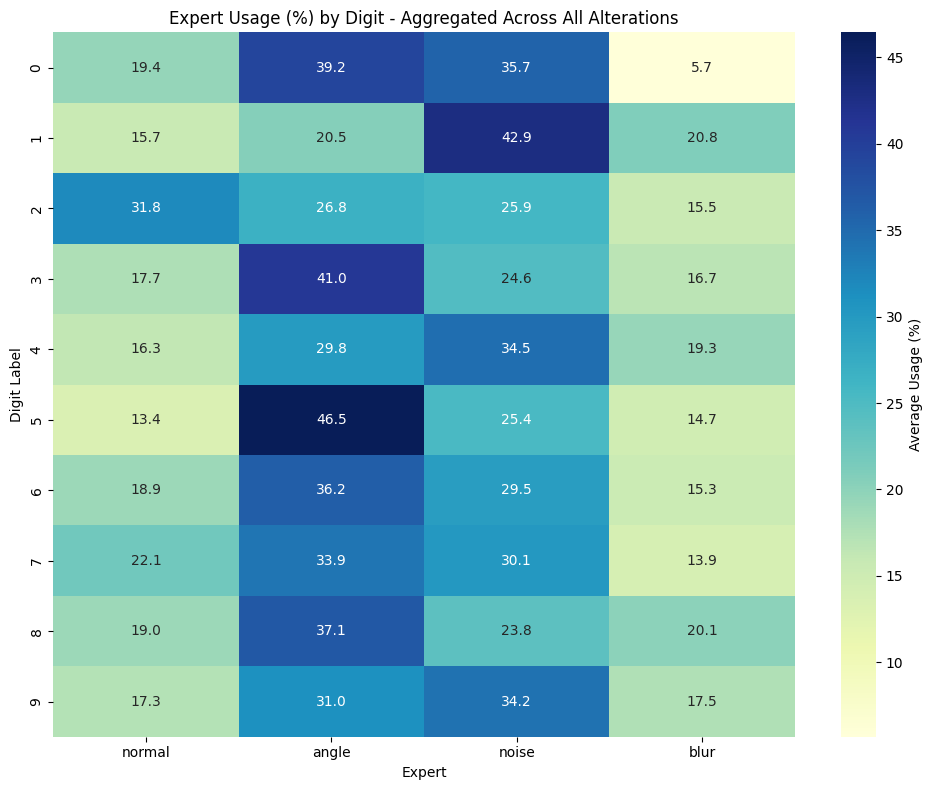

: 

In [ ]:
import seaborn as sns
plt.figure(figsize=(10, 8))

aggregated_usage = np.zeros((10, 4))  # 10 labels, 4 experts

for label in range(10):
    total_usage = np.zeros(4)
    for alteration in expert_names:
        usage_array = results[label][alteration]
        total_usage += usage_array
    aggregated_usage[label, :] = total_usage / len(expert_names) * 100  # Average percentage

sns.heatmap(
    aggregated_usage,
    annot=True,
    fmt=".1f",
    cmap="YlGnBu",
    xticklabels=expert_names,
    yticklabels=[str(i) for i in range(10)],
    cbar_kws={'label': 'Average Usage (%)'}
)
plt.xlabel("Expert")
plt.ylabel("Digit Label")
plt.title("Expert Usage (%) by Digit - Aggregated Across All Alterations")
plt.tight_layout()
plt.savefig('expert_usage_aggregated.png', dpi=300, bbox_inches='tight')
plt.show()


In this chart it is more clear that the noise expert is the most used in all labels (classe of the dataset) with the lower percentage of call being 46.7% percent of the time wich is still very high and far from a 25% if all experts were equally used.
This could indicate that the noise expert is simply better at generalizing to other types of corruption.